# Anomaly detection using a global normalization

In [5]:
using CABLAB

In this example we combine the subsample-quantile approach with the extreme event detection methods. We first take some sample grid cells out of the cube, calculate the 40% and 60% quantile to normalize the variables against each other. We also use this subsample to train the optimization parameters used for the extreme event detectioon methods. 

In [9]:
c=Cube("/Net/Groups/BGI/scratch/fgans/cubecopy/datacube/")

CABLAB data cube at /Net/Groups/BGI/scratch/fgans/cubecopy/datacube/
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2000-01-01T00:00:00 to 2011-01-01T00:00:00 at 8daily time steps
Variables:           BHR_VIS BurntArea DHR_VIS Emission GPP Ozone Precip Rg SoilMoisture TER fpar fpar_fluxcom t2m 


In [10]:
cdata=getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(30,65),variable=["t2m","Rg","fpar_fluxcom"])
cdata_filled=mapCube(gapFillMSC,cdata)
cdata_anom=mapCube(removeMSC,cdata_filled)

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2000-01-01T00:00:00 to 2010-12-27T00:00:00
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Variable            Axis with elements: t2m Rg fpar_fluxcom 


In [11]:
sp=sampleLandPoints(cdata,3000)
spfilled=mapCube(gapFillMSC,sp)
spanom=mapCube(removeMSC,spfilled)

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2000-01-01T00:00:00 to 2010-12-27T00:00:00
Spatial points axis with 3000 points
Variable            Axis with elements: t2m Rg fpar_fluxcom 


In [12]:
spquants = mapCube(CABLAB.Proc.Stats.timespacequantiles,readCubeData(spanom),[0.4,0.6])
spquants.data

2×3 Array{Float32,2}:
 -0.169366  -0.186479  -0.00231777
  0.176965   0.337191   0.00723114

In [13]:
function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1])+abs(quantiles[2]))/2
    for i in eachindex(xin)
        xout[i]=xin[i]/absm
    end
end
registerDATFunction(scaleCubeQuantiles,((TimeAxis,),(CategoricalAxis{Float64,:Quantile},)),(TimeAxis,),inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1);

The we normalize the cube by dividing each value by the absmean of the 40% and 60% quantile.

In [14]:
cdata_norm=mapCube(scaleCubeQuantiles,(cdata_anom,spquants))

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2000-01-01T00:00:00 to 2010-12-27T00:00:00
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Variable            Axis with elements: t2m Rg fpar_fluxcom 


In [15]:
using StatsBase
function getTrainArray(smallcube)
    dmem=readCubeData(smallcube).data;
    sampletimes=rand(1:506,5000)
    sampleplaces=rand(1:2000,5000)
    trainarray=Float64[dmem[sampletimes[i],sampleplaces[i],j] for i=1:5000,j=1:3]
    nnans=mapreducedim(isnan,+,trainarray,2)
    trainarray=trainarray[nnans.==0,:];
    trainarray
end
trainarray=getTrainArray(spanom);

LoadError: LoadError: BoundsError: attempt to access 5000×3 Array{Float64,2} at index [Bool[false; true; true; true; false; false; false; true; false; true; true; false; true; false; true; false; false; true; false; true; false; false; true; true; false; true; true; true; false; true; false; true; false; false; true; true; true; true; true; false; true; false; true; true; true; true; false; false; false; true; false; false; false; false; true; true; false; false; false; false; false; true; true; true; true; false; true; false; true; true; true; true; false; false; false; false; true; false; false; false; false; true; true; false; false; true; true; false; false; true; false; true; false; true; true; true; false; true; false; true; true; false; true; false; false; true; true; false; false; false; true; true; false; true; false; false; true; false; false; true; true; true; false; true; true; true; false; false; false; true; true; true; true; false; false; false; true; true; false; false; true; true; true; true; false; false; false; true; true; false; true; false; true; true; false; false; false; false; true; true; false; true; true; true; false; false; true; false; true; true; true; true; true; false; false; false; true; true; true; true; false; false; false; false; false; false; true; false; true; false; true; false; false; false; true; false; true; true; false; true; false; false; false; false; true; true; false; true; true; true; false; true; true; false; true; false; true; true; true; false; true; true; true; true; false; false; false; true; false; true; true; false; false; true; true; true; false; false; false; true; true; true; false; true; false; false; true; false; true; false; false; true; false; false; false; true; true; true; false; true; true; true; true; true; true; true; true; false; false; true; false; true; true; true; false; false; false; false; false; false; false; true; true; true; false; false; false; true; true; true; true; true; false; false; true; false; false; true; true; true; true; false; false; false; true; true; true; false; false; true; true; true; false; true; true; true; true; false; true; false; true; false; false; false; true; false; true; true; true; false; true; true; true; true; false; false; true; true; true; true; true; false; true; true; false; false; false; true; false; true; true; true; false; false; false; false; true; false; true; false; false; true; true; true; true; false; true; true; true; true; true; true; true; true; true; false; true; false; true; false; true; false; true; false; false; true; true; true; true; false; true; false; true; false; true; true; false; false; true; false; false; true; false; false; false; true; true; true; false; true; true; false; true; true; true; true; true; true; true; true; true; true; true; false; false; true; false; true; true; false; false; true; true; true; true; false; true; true; true; false; false; false; true; true; true; false; false; true; true; true; false; true; false; true; false; true; true; true; true; false; true; true; false; false; false; true; true; true; false; true; false; false; true; true; false; true; false; true; true; false; false; false; true; true; true; true; true; false; true; true; true; true; false; true; true; true; true; false; false; true; false; false; true; false; false; true; true; true; false; false; true; true; false; true; false; false; true; true; true; true; false; true; true; false; false; true; true; true; false; false; false; true; true; true; false; false; true; true; true; false; false; true; false; false; false; true; false; false; false; true; false; true; true; false; false; false; true; true; true; true; false; true; false; true; true; false; false; false; false; false; false; false; true; true; false; false; true; false; false; true; true; true; false; true; false; false; true; false; false; false; true; true; false; true; false; true; false; true; false; false; true; false; true; true; false; true; false; false; true; true; true; true; true; true; false; false; false; true; true; true; true; false; false; true; true; false; true; false; true; true; true; false; false; true; false; true; true; true; true; true; true; true; false; false; true; false; true; true; true; true; false; false; true; true; false; true; false; true; true; true; true; true; false; true; false; true; true; true; false; true; true; false; true; true; false; false; true; true; true; false; true; true; true; true; false; true; false; true; true; false; true; false; false; false; true; true; true; false; true; true; true; true; false; true; true; true; false; true; false; true; true; false; false; false; false; false; false; true; true; false; false; false; true; true; false; true; true; false; true; true; false; true; false; true; true; false; false; true; true; false; true; true; true; true; true; false; true; true; false; false; true; false; true; false; false; true; false; false; true; false; true; false; true; false; false; false; false; false; false; true; true; false; false; false; true; false; false; true; false; false; true; false; false; true; true; true; false; true; false; false; true; true; false; false; false; false; true; false; true; true; false; false; false; true; true; true; true; true; true; false; true; false; true; false; false; true; false; false; true; true; true; true; true; false; false; true; false; true; true; false; true; true; true; false; false; true; true; true; true; false; false; true; true; true; false; false; true; true; true; true; true; false; true; false; true; false; true; false; false; false; true; false; true; true; true; true; false; true; true; true; true; false; true; true; true; true; true; false; true; true; false; true; false; true; false; true; true; true; true; true; true; false; true; true; true; false; false; true; false; false; true; true; true; false; false; false; true; true; true; false; true; true; true; false; true; false; true; true; false; true; true; true; true; false; false; false; false; false; false; true; false; true; true; true; true; false; true; false; true; false; true; true; true; true; false; true; false; true; true; true; false; true; true; false; false; true; true; false; true; true; true; true; true; false; true; false; true; false; false; true; true; false; true; false; true; true; true; false; true; false; false; true; true; false; false; false; false; true; true; true; false; true; false; true; true; true; true; true; false; true; true; false; false; false; false; true; true; false; true; false; true; true; false; true; true; true; true; true; true; true; true; true; false; true; true; true; false; true; true; true; false; false; true; true; false; true; true; true; true; false; false; true; false; true; true; false; true; false; true; true; false; true; true; true; false; true; true; true; false; false; true; true; false; true; false; false; false; false; true; false; false; true; false; true; false; false; true; true; true; true; true; true; true; true; true; true; false; false; true; true; true; true; false; true; true; true; true; true; false; true; false; false; false; false; true; true; true; true; true; false; false; false; true; false; true; true; true; true; true; false; false; true; false; false; true; true; true; false; true; false; false; true; false; false; false; true; true; true; false; false; false; false; true; false; true; true; false; true; true; false; true; true; false; true; true; true; true; false; false; false; true; false; true; false; false; true; false; true; true; true; false; false; true; true; false; true; true; false; true; true; true; false; true; true; false; false; false; false; false; false; false; false; true; true; true; true; false; false; true; true; true; true; true; false; true; false; true; true; true; true; true; false; true; true; true; true; true; false; true; true; false; true; true; true; false; false; false; false; true; true; true; true; false; false; true; true; false; true; false; true; false; false; true; true; false; true; true; true; false; true; false; true; false; false; false; true; true; true; true; false; false; true; true; true; true; true; true; false; true; false; true; false; false; true; true; true; true; false; true; false; true; false; true; false; false; false; false; true; true; true; true; true; false; true; true; false; false; true; true; false; false; true; false; true; true; true; false; true; true; true; true; false; true; false; false; false; true; true; false; false; true; true; true; false; false; true; false; true; true; false; true; true; true; true; true; true; true; true; true; true; true; true; false; false; true; true; false; true; false; true; true; true; true; true; false; true; true; true; false; false; false; true; false; true; false; false; true; true; true; false; true; false; false; true; true; true; true; true; true; false; true; false; false; true; false; true; false; true; true; true; false; false; true; true; false; false; true; true; true; false; true; false; true; false; true; true; true; false; true; true; false; false; false; false; false; false; true; true; false; true; true; true; false; true; false; false; false; false; true; true; false; true; false; true; true; false; false; true; false; true; true; true; false; false; false; true; false; true; true; true; false; true; true; false; true; false; true; false; false; true; true; false; false; true; true; true; true; true; true; true; false; true; true; true; true; false; false; true; true; false; true; true; true; false; false; true; false; false; true; true; true; true; true; false; false; true; false; true; false; true; true; true; true; true; true; true; false; true; true; true; true; true; false; true; true; false; true; false; true; true; true; false; true; false; true; true; false; true; true; true; true; true; true; true; false; true; true; true; true; true; false; true; false; false; true; true; true; true; false; true; false; true; false; false; false; true; true; true; false; false; true; false; true; false; true; true; true; false; true; true; true; false; true; true; true; false; false; false; false; true; true; true; false; true; false; false; true; true; true; true; false; true; true; false; true; true; true; false; true; true; true; true; true; false; false; false; true; true; false; false; false; true; false; true; false; true; true; true; false; true; true; false; true; false; false; false; true; true; false; false; true; true; false; true; true; true; true; true; false; false; true; true; true; true; true; false; true; false; true; true; true; true; true; true; false; false; false; false; true; false; false; true; false; true; true; true; true; false; false; true; false; true; true; true; true; false; true; true; true; false; false; false; true; true; false; true; false; true; true; false; true; false; false; true; false; true; true; true; false; true; true; false; true; true; true; true; false; false; true; true; true; false; false; false; false; true; true; false; true; false; false; true; true; true; false; false; true; false; true; true; false; true; true; false; true; true; true; true; true; false; true; false; true; true; false; true; true; true; true; true; true; false; false; true; true; true; false; false; true; true; false; true; false; false; false; true; true; true; true; false; false; true; false; true; false; false; true; true; true; true; true; true; true; true; true; false; true; true; false; true; true; true; true; true; true; true; true; true; true; false; true; true; false; false; false; false; false; false; true; true; false; true; true; true; true; false; true; false; true; true; true; true; false; true; false; true; true; true; false; true; false; true; true; true; true; false; false; false; false; false; true; false; true; false; false; false; true; true; true; false; true; false; true; true; true; false; false; false; false; true; true; true; true; true; true; false; false; false; false; true; true; true; false; false; true; true; true; true; false; false; false; true; true; true; true; true; true; false; true; false; true; true; true; true; true; false; false; false; false; true; false; true; false; true; true; true; false; false; false; true; false; false; true; false; false; false; false; false; true; true; false; true; false; true; true; false; false; true; true; true; true; false; false; false; true; true; false; false; false; false; true; false; false; true; false; true; true; true; false; false; false; true; true; false; false; false; true; true; false; false; true; false; false; false; true; false; true; false; false; true; true; false; true; false; false; true; true; false; false; false; false; true; true; true; false; true; true; true; true; true; true; true; true; false; true; false; false; true; true; false; false; false; false; false; false; false; true; false; false; false; false; true; true; false; true; false; true; false; true; false; false; false; true; false; false; false; true; false; false; false; true; true; false; true; true; true; true; true; false; true; true; false; true; true; false; true; false; false; true; false; true; true; false; true; true; true; true; false; true; true; false; true; true; true; false; true; true; false; true; false; false; false; true; false; true; true; true; true; true; true; true; false; true; true; true; true; true; true; false; true; true; true; true; false; false; true; false; true; true; false; false; false; false; true; false; true; true; false; false; false; true; true; true; false; true; false; false; true; true; true; false; false; true; true; true; false; true; true; true; false; false; false; true; true; true; false; false; false; false; false; true; true; false; true; true; true; false; true; true; true; true; true; true; false; true; false; false; false; false; true; false; false; false; true; false; true; true; true; true; true; false; false; true; true; true; true; true; true; true; true; true; true; true; true; true; true; true; false; false; false; false; true; true; false; false; true; true; true; true; false; true; true; true; true; false; true; false; true; true; false; true; false; true; false; false; false; false; false; false; true; false; false; true; false; true; true; true; true; false; false; true; false; false; false; true; false; true; true; true; false; true; true; false; true; true; true; false; false; true; false; true; false; false; false; true; false; true; true; false; false; true; true; false; true; true; true; false; false; true; true; true; true; true; false; true; true; true; true; true; false; true; false; false; true; true; true; true; true; true; false; true; true; false; false; true; false; true; true; true; false; true; true; true; true; true; true; true; true; false; true; false; false; true; false; true; true; true; true; true; false; false; false; true; true; true; true; true; false; false; false; true; false; true; true; false; true; false; true; true; true; false; true; true; false; false; true; false; true; true; false; true; true; false; false; false; false; false; false; false; true; false; true; true; true; true; true; false; false; true; true; true; false; true; true; false; true; true; true; true; true; true; true; false; true; true; false; false; true; true; false; false; true; true; true; false; false; false; false; true; false; false; false; false; false; false; false; false; false; false; true; false; false; false; false; false; false; false; false; true; false; false; false; false; true; true; false; false; true; false; true; true; false; true; false; true; true; false; true; true; true; false; true; true; true; true; false; true; true; true; false; true; true; true; false; true; false; false; false; false; false; true; true; true; false; false; false; true; false; true; false; true; false; true; true; false; false; false; false; true; false; true; true; true; false; false; true; true; false; true; true; false; true; true; true; true; true; false; false; true; true; true; true; false; false; true; false; true; true; false; true; true; false; false; false; false; true; true; true; false; true; true; false; true; true; true; false; true; true; true; true; false; true; false; true; false; true; false; true; true; true; true; false; false; true; false; false; false; true; true; false; true; true; true; false; false; false; false; true; true; false; false; false; true; false; true; true; true; true; false; true; true; false; false; true; true; true; false; true; true; false; false; true; true; true; true; true; false; false; true; true; true; true; false; false; true; true; true; true; true; false; true; false; true; true; true; true; true; false; true; true; true; false; true; false; false; false; false; true; false; false; false; false; true; false; false; true; true; true; false; false; true; true; true; false; false; true; true; true; false; false; true; false; true; true; true; true; false; false; false; false; false; false; false; true; true; true; true; false; true; false; true; true; true; true; true; true; true; false; true; false; false; true; true; false; true; false; true; true; true; false; true; true; true; true; true; false; true; true; false; false; false; true; false; true; true; true; true; false; false; true; true; false; false; false; false; true; false; false; true; false; true; false; true; true; false; false; false; false; false; false; false; true; false; true; true; true; false; false; true; true; true; true; false; false; true; true; false; false; true; false; true; true; false; false; true; false; true; true; false; true; true; false; false; false; false; false; true; true; true; true; true; false; false; true; false; false; true; true; true; false; true; false; false; true; true; true; true; false; false; false; false; false; true; false; true; false; false; true; true; false; true; false; true; true; true; false; true; false; false; false; false; true; false; true; true; false; true; true; true; true; true; true; false; true; false; false; true; false; true; false; true; true; true; false; true; true; true; true; true; false; true; false; true; false; true; false; true; true; true; true; false; false; true; false; false; true; false; true; false; true; false; true; true; true; false; true; false; false; false; false; true; true; false; false; false; true; false; true; false; false; true; false; true; false; false; false; true; true; false; true; false; true; true; true; true; true; false; false; true; false; false; true; false; true; true; true; true; false; true; true; true; true; false; false; true; false; true; true; true; true; true; false; false; false; false; true; true; false; false; true; true; true; true; true; true; false; false; true; false; true; false; false; false; false; false; false; true; false; false; false; true; false; false; false; false; true; true; true; false; false; false; false; true; false; false; true; true; false; true; false; false; false; false; false; false; true; false; false; false; false; true; true; true; true; true; false; true; true; true; false; false; false; true; true; true; true; false; true; false; true; true; true; true; true; true; true; true; false; true; true; true; true; false; false; false; true; true; true; true; false; true; true; false; false; true; false; true; true; true; true; true; true; true; true; true; true; false; false; false; true; true; false; true; false; false; false; false; true; false; false; false; true; true; false; false; true; true; false; true; true; false; false; true; false; true; true; false; true; true; false; false; true; true; true; true; true; true; true; true; true; true; true; false; false; true; true; true; true; true; true; false; false; true; true; false; true; false; false; false; true; false; false; true; true; false; false; true; true; true; true; false; false; false; true; false; false; false; false; true; false; true; true; true; true; true; true; true; true; false; true; false; true; false; true; true; true; true; false; true; false; true; true; true; false; true; false; true; false; false; true; true; false; true; true; false; false; false; true; true; true; true; false; false; false; true; true; false; true; true; false; true; true; false; true; true; true; true; false; false; true; true; false; true; true; false; true; true; true; false; true; true; false; true; false; true; true; true; true; true; false; false; true; false; false; true; true; true; false; true; false; true; true; true; false; false; false; true; false; true; false; false; true; true; true; true; true; true; true; false; false; false; true; true; true; true; false; false; true; false; false; true; false; false; true; false; true; false; false; true; false; false; false; true; true; false; false; false; false; false; true; true; false; true; false; false; true; true; true; true; true; true; true; false; false; true; false; true; false; true; true; true; true; false; true; false; true; true; false; true; false; false; false; true; false; false; true; true; true; false; true; false; true; false; true; false; false; true; true; true; false; false; true; true; true; true; true; true; true; true; false; false; false; false; true; false; false; true; true; false; false; false; true; true; true; true; false; true; true; false; true; true; false; true; true; false; false; false; true; true; false; false; true; true; false; true; true; false; true; false; false; true; true; false; true; true; true; true; false; true; false; false; true; true; true; true; false; false; true; true; true; false; false; true; true; true; false; true; true; false; true; false; false; false; false; false; false; true; true; true; false; false; true; false; false; false; true; true; false; true; false; true; false; true; false; true; true; true; true; false; true; true; true; false; false; false; false; true; false; false; true; true; true; false; false; false; true; true; true; true; false; true; true; false; true; false; false; true; true; false; false; true; false; false; false; false; false; true; true; true; false; true; true; true; false; true; true; true; false; false; true; false; false; true; true; true; true; true; true; false; true; true; true; false; true; true; false; false; true; true; false; true; true; false; true; true; true; false; true; true; true; true; false; true; false; false; false; true; false; false; true; true; true; false; true; true; false; false; true; true; true; true; true; true; false; true; false; false; true; false; true; true; false; true; true; true; true; true; true; true; true; true; false; false; true; true; false; true; false; false; true; false; false; false; true; false; false; true; false; true; false; false; true; false; true; true; true; false; true; true; true; false; true; true; true; true; false; false; true; true; true; false; false; true; false; true; false; true; false; true; true; true; true; false; false; true; false; false; false; false; true; true; true; true; false; false; false; false; true; true; false; true; false; false; false; false; false; true; false; true; true; false; true; true; false; false; true; true; false; true; false; false; true; true; true; true; true; true; true; false; true; true; true; true; false; true; true; true; false; true; true; false; true; false; true; true; true; false; false; true; false; false; false; true; true; false; false; false; false; true; true; true; true; true; true; true; true; true; true; true; true; false; false; true; true; true; false; true; true; false; true; true; true; false; true; false; false; true; false; true; true; true; false; false; false; true; false; false; true; true; true; false; true; true; true; false; true; true; false; true; true; false; false; true; true; false; true; true; true; true; true; false; false; false; false; true; true; true; false; false; true; true; true; true; true; false; false; true; true; true; false; false; false; false; false; true; false; true; true; true; false; true; false; true; true; false; false; false; true; true; true; true; false; true; false; true; true; true; false; true; true; true; false; false; true; true; true; false; true; false; true; false; true; true; false; false; true; false; true; true; false; true; false; true; true; true; true; true; true; true; true; false; false; false; true; true; false; false; true; false; false; false; true; false; true; false; false; false; true; true; true; true; false; false; false; false; false; true; false; false; false; false; true; false; true; true; true; true; false; false; true; true; true; true; true; false; true; true; false; true; true; false; true; false; true; true; true; false; false; false; true; true; true; false; false; true; true; true; false; false; true; false; true; false; true; false; false; true; true; true; false; false; true; true; true; true; true; false; false; true; false; true; true; true; false; false; true; false; false; true; true; false; false; true; true; true; false; true; false; false; true; false; false; false; true; false; false; false; true; true; true; true; false; true; true; true; true; true; false; true; false; true; false; true; false; false; true; true; true; true; true; true; false; true; true; false; true; true; true; false; false; false; false; false; true; true; false; true; true; true; true; false; true; false; true; false; false; false; true; true; false; true; false; true; true; false; true; true; true; false; true; true; true; false; true; false; false; false; false; true; false; false; true; false; false; true; true; false; false; false; true; true; false; false; true; true; false; true; false; true; true; false; true; false; true; false; true; true; true; true; false; false; false; false; false; false; false; false; true; true; false; true; true; false; true; false; false; false; false; false; true; false; true; false; true; false; true; true; true; true; false; true; true; true; true; true; false; true; true; true; true; true; true; false; false; true; true; true; true; false; true; true; false; true; true; true; true; true; false; false; false; true; false; false; true; false; false; true; true; true; false; false; false; false; true; false; false; false; true; true; false; true; false; false; false; false; true; true; false; true; false; true; false; false; true; true; true; false; false; true; false; true; true; false; false; false; true; false; true; false; true; false; true; false; false; false; false; false; false; true; false; false; false; true; true; false; false; true; false; false; true; true; true; false; false; true; true; true; true; false; true; false; false; true; true; true; true; true; true; false; false; true; false; true; false; false; false; true; true; false; true; false; false; true; false; false; false; true; false; true; true; true; false; true; true; false; true; false; false; false; false; true; false; true; true; true; true; false; true; false; true; false; true; false; false; true; true; true; true; true; true; false; true; true; true; true; true; true; false; false; true; true; true; true; false; false; false; true; false; true; false; true; false; false; true; true; true; false; false; false; true; false; false; false; true; false; false; true; true; true; true; false; false; false; false; true; false; true; true; true; false; false; false; false; false; false; true; false; false; true; false; true; true; false; true; true; false; true; false; false; true; false; true; false; false; true; true; false; false; true; false; false; false; true; false; false; true; false; true; false; false; true; false; true; true; true; true; true; true; false; false; false; true; true; false; true; false; false; false; true; true; true; true; false; false; true; true; true; true; true; false; true; false; true; true; true; false; false; false; true; true; false; true; true; false; true; false; false; false; true; true; false; false; false; true; true; true; false; false; false; true; true; true; false; false; false; false; true; true; true; false; true; false; false; true; true; true; true; false; true; false; true; true; false; true; false; true; true; false; true; true; false; true; false; true; false; true; false; true; false; true; true; true; true; true; true; true; true; false; true; true; false; false; false; true; true; false; false; true; false; false; false; true; true; false; true; false; false; true; true; false; true; true; false; true; true; true; true; true; true; true; false; false; false; true; false; false; false; true; false; true; true; false; true; false; false; true; true; true; true; true; true; false; true; false; false; true; true; false; false; true; true; false; false; true; false; true; false; true; false; true; false; true; true; false; false; true; true; true; true; false; true; false; true; false; false; false; false; false; false; true; false; false; true; true; false; false; false; false; false; true; true; true; true; false; false; false; true; false; true; true; false; false; true; false; false; true; true; true; true; false; false; false; true; false; true; false; false; true; true; true; true; true; false; false; true; false; true; true; true; true; true; true; true; false; false; true; true; false; false; true; true; false; true; false; false; true; true; false; false; true; true; true; false; true; true; true; false; true; true; false; false; true; true; true; true; false; false; true; true; true; true; false; false; false; false; true; false; true; false; true; true; true; true; false; true; true; true; true; true; false; true; true; true; true; false; false; false; false; true; true; true; true; true; true; true; false; true; true; false; false; true; true; true; true; true; false; false; false; true; false; false; true; true; true; false; true; false; false; false; false; true; true; true; false; true; true; true; false; true; true; true; false; false; true; true; false; true; false; true; false; true; false; true; true; true; true; false; true; true; true; true; true; false; false; true; false; true; true; true; false; true; true; false; false; false; false; false; true; false; true; true; false; false; false; true; false; true; false; true; true; false; true; false; true; false; true; true; false; true; true; true; false; true; true; true; true; true; false; false; false; true; false; true; true; true; true; true; false; false; false; false; true; false; true; true; true; false; false; false; true; false; true; false; true; false; false; true; false; true; true; false; false; false; true; false; true; true; true; false; true; false; false; true; true; false; false; true; false; false; true; false; true; true; true; false; true; true; false; false; false; true; true; false; true; true; true; true; true; true; true; true; true; false; true; true; true; true; true; true; true; true; true; false; false; false; false; false; true; true; false; false; true; true; false; true; false; false; true; false; true; true; true; false; true; true; false; true; true; true; true; true; true; false; false; true; true; true; false; false; true; false; false; true; true; false; true; true; false; true; false; true; true; false; true; true; false; true; false; false; true; true; true; true; true; false; false; false; true; false; true; false; false; true; true; true; false; false; true; false; false; false; true; true; false; true; true; true; true; true; true; true; false; true; false; true; true; false; true; false; false; false; false; false; true; true; true; false; true; false; false; true; false; false; false; false; true; false; false; true; true; true; true; true; true; false; true; true; false; true; true; false; true; true; true; false; true; false; false; true; false; false; false; false; true; true; true; true; true; false; true; false; false; false; false; false; true; true; true; true; true; true; false; true; true; false; false; false; false; false; true; true; true; false; true; true; true; false; false; true; true],Colon()]
while loading In[15], in expression starting on line 11

**Comments: AccessOutofBounds Error**

In [14]:
addprocs(10);

In [16]:
CABLAB.DAT.init_DATworkers()

In [17]:
@time xout2=mapCube(DAT_detectAnomalies!,cdata_norm,["REC", "KDE", "KNN_Gamma"],trainarray)

 82.173815 seconds (10.00 M allocations: 702.829 MB, 0.28% gc time)


Temporary Data Cube with the following dimensions
time                Axis with 506 Elements from 2000-01-01T00:00:00 to 2010-12-27T00:00:00
MethodAxis          Axis with elements: REC KDE KNN_Gamma 
longitude           Axis with 180 Elements from -10.0 to 34.75
latitude            Axis with 140 Elements from 65.0 to 30.25


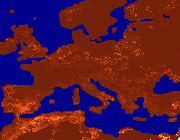

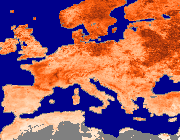

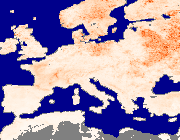

In [22]:
display(plotMAP(xout2,time=160,method=1))
display(plotMAP(xout2,time=160,method=2))
display(plotMAP(xout2,time=160,method=3))

In [23]:
meanscore=mapCube(timeMean,xout2)

Temporary Data Cube with the following dimensions
MethodAxis          Axis with elements: REC KDE KNN_Gamma 
longitude           Axis with 180 Elements from -10.0 to 34.75
latitude            Axis with 140 Elements from 65.0 to 30.25


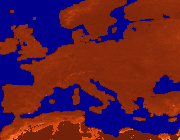

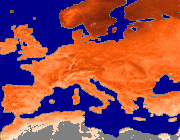

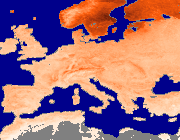

In [25]:
display(plotMAP(meanscore,method=1))
display(plotMAP(meanscore,method=2))
display(plotMAP(meanscore,method=3))

For all methods one can observe the effect of the global normalization. This leads to an overdetection of extremes in the zones where variablility of the underlying variables is highest. 